<a href="https://colab.research.google.com/github/skosch/YinYangFit/blob/master/YinYangFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up TF2 and import dependencies

In [0]:
try:
  # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    #%tensorflow_version 1.x
except Exception:
    pass

TensorFlow 2.x selected.


In [0]:
import itertools
import os

import numpy as np
pi = np.pi
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.interpolation import affine_transform
import tensorflow as tf
import random; random.seed()
import math
import pickle
import os
from tqdm import tqdm as tqdm
import sys
from functools import reduce
import random
from itertools import cycle, islice, product
import operator

!pip install --quiet --upgrade git+git://github.com/simoncozens/tensorfont.git
!pip install --quiet fonttools

from tensorfont import Font

print("✓ Dependencies imported.")

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

     |████████████████████████████████| 890kB 2.9MB/s 
     |████████████████████████████████| 727kB 2.8MB/s 
✓ Dependencies imported.
TF version: 2.0.0-rc2
GPU is available


### Download font files

In [0]:
#!wget -q -O OpenSans-Regular.ttf https://github.com/googlefonts/opensans/blob/master/ttfs/OpenSans-Regular.ttf?raw=true
!wget -q -O Roboto.ttf https://github.com/google/fonts/blob/master/apache/roboto/Roboto-Regular.ttf?raw=true
#!wget -q -O Roboto.otf https://github.com/AllThingsSmitty/fonts/blob/master/Roboto/Roboto-Regular/Roboto-Regular.otf?raw=true
!wget -q -O DroidSerif.ttf https://github.com/datactivist/sudweb/blob/master/fonts/droid-serif-v6-latin-regular.ttf?raw=true
!wget -q -O CrimsonItalic.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Italic.otf?raw=true
#!wget -q -O CrimsonBold.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Bold.otf?raw=true 
#!wget -q -O CrimsonRoman.otf https://github.com/alif-type/amiri/blob/master/Amiri-Regular.ttf?raw=true

!wget -q -O CrimsonRoman.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Roman.otf?raw=true
print("✓ Font file(s) downloaded.")

✓ Font file(s) downloaded.


## Create Gabor filter bank

In [0]:
def get_filter_bank(number_scales, skip_scales, number_orientations, height, width, display_filters=False, same_angles=False):
    def rotated_mgrid(oi):
        """Generate a meshgrid and rotate it by RotRad radians."""
        rotation = np.array([[np.cos(np.pi*oi/number_orientations),  np.sin(np.pi*oi/number_orientations)],
                            [-np.sin(np.pi*oi/number_orientations), np.cos(np.pi*oi/number_orientations)]])
        hh = height / 2
        bw = width / 2
        y, x = np.mgrid[-hh:hh, -bw:bw]
        y += 0 if height % 2 == 0 else 0.5
        x += 0 if width % 2 == 0 else 0.5
        return np.einsum('ji, mni -> jmn', rotation, np.dstack([x, y]))


    def get_filter(f_0, theta_0, same_angles, stretch):

        # x,y grid
        x, y = rotated_mgrid(theta_0)

        # How far away the peak is from the middle.
        # Min. desired wavelength = 1.5px
        # Max. desired wavelength = width / 4
        min_wavelength = 1.5
        max_wavelength = width * 0.34
        #desired_wavelength = 1.5 + (width / (4*number_scales)) * f_0
        desired_wavelength = (max_wavelength - min_wavelength) * f_0**2 / (number_scales - 1)**2 + min_wavelength
        freq_x = width * 0.5 / desired_wavelength
        # How wide the peak is
        sigma_x = 0.8 * freq_x
        sigma_y = 0.8 * freq_x / stretch
        full_filter = np.exp(-(x-freq_x)**2/sigma_x**2 -y**2/sigma_y**2)
        full_filter *= (1 - np.exp(-x**2/(freq_x)**2 -y**2/(freq_x)**2))

        return full_filter


    bank = np.zeros((height, width, number_scales, number_orientations)).astype(np.complex64)
    for s in range(number_scales):
        for o in range(number_orientations):
            for stretch in [1]: #range(number_orientations):
                real = get_filter(s + skip_scales, o, same_angles, stretch)# + get_filter(s, o + number_orientations, same_angles)
                imag = 0 #get_filter(s, o, same_angles) - get_filter(s, o + number_orientations, same_angles)
                cfilter = real + (imag * 1j)
                if display_filters and o == 0:
                    plt.imshow(np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(cfilter), [height, width]))), cmap="inferno")
                    plt.colorbar()
                    plt.show()
                bank[:, :, s, o] = cfilter

    return bank[:, :, :, :] # [height, width, sizes, orientations]

#get_filter_bank(20, 6, 129, 195, True, True)

## Load font data and set up global parameters

In [0]:
glyph_char_list = "abcdeghijlmnopqrstuzywvxkf"
#glyph_char_list = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

# ==== Create Font ====
factor = 0.9 #1.539  # This scales the size of everything
f = Font("Roboto.ttf", 34 * factor) # Roboto.ttf CrimsonRoman.otf
box_height = f.full_height_px
box_width = int(122 * factor)
box_width += (box_width + 1) % 2
print("Box size:", box_height, "×", box_width)

batch_size = 1  # must be divisible by 8 to work on TPU
n_sample_distances = 9 # should be an odd number

n_sizes = 11
n_pseudo_orientations = 4
n_orientations = 4

filter_bank = get_filter_bank(n_sizes, 1, n_pseudo_orientations, box_height, box_width, False, True)[:, :, :, [0, 1, 2, 3]]

Box size: 67 × 109


## Rasterize the glyphs into numpy arrays, and extract their ink widths in pixels


In [0]:
def apply_filter_bank(input_image):
    # First, convert the input to the frequency domain using the FFT.
    input_in_freqdomain = np.fft.fft2(input_image + 1j * np.zeros_like(input_image), [box_height, box_width])
                                             
    # Then, shift the zero frequencies into the middle.
    shifted_input_in_freqdomain = np.fft.fftshift(input_in_freqdomain, [0, 1])
    
    # Filters are already in frequency domain and not shifted.
    # Now multiply the inputs (at all distances) with all of the filters
    fft_product = shifted_input_in_freqdomain[:, :, None, None] * filter_bank
    fft_product_reshaped = np.einsum("hwso->sohw", fft_product)
    
    # Back to space domain
    return np.einsum("sohw->hwso", np.fft.ifft2(np.fft.ifftshift(fft_product_reshaped, [2, 3]), [box_height, box_width])).astype(np.complex64)

def get_glyph_data_with_filtered_as_dict(glyph_char):
    """
    Returns a dict containing relevant glyph data, including filtered images.
    @param glyph_char: string of length 1
    """
    glyph_image = f.glyph(glyph_char).as_matrix(normalize=True).with_padding_to_constant_box_width(box_width).astype(np.float32)

    return {
        'glyph_char': glyph_char,
        'glyph_image': glyph_image,
        'glyph_ink_width': f.glyph(glyph_char).ink_width,
        'glyph_filtered_images': apply_filter_bank(glyph_image),
    }

def get_sample_distances_and_translations(gd1, gd2, target_ink_distance):
    """Returns a list of distances at which the box images have to be shifted left and right before they can be overlaid to sample their normalized interaction"""
    total_width_at_minimum_ink_distance = gd1['glyph_ink_width'] + gd2['glyph_ink_width'] - f.minimum_ink_distance(gd1['glyph_char'], gd2['glyph_char'])
    
    relative_sample_distances = [0]
    simax = int((n_sample_distances - 1)/2)
    
    pos_ad = factor #/ 2.
    neg_ad = -((target_ink_distance / simax))
    next_pos = pos_ad
    next_neg = neg_ad
    for si in range(simax):
        # always append a positive, and then ...
        relative_sample_distances.append(next_pos)
        next_pos += pos_ad
        pos_ad *= 1.15
        # ... append a negative only if there is room
        if target_ink_distance + next_neg >= 1:
            relative_sample_distances.append(next_neg)
            next_neg += neg_ad
        else:
            relative_sample_distances.append(next_pos)
            next_pos += pos_ad
            pos_ad *= 1.15
    
    relative_sample_distances.sort()
    
    zero_index_val = relative_sample_distances.index(0)
    
    sample_distances = (np.array(relative_sample_distances) + target_ink_distance)
    sample_distances_left = np.ceil(sample_distances / 2)
    sample_distances_right = np.floor(sample_distances / 2)
    
    total_ink_width = gd1['glyph_ink_width'] + gd2['glyph_ink_width']
    ink_width_left = np.floor(total_ink_width / 4)
    ink_width_right = np.ceil(total_ink_width / 4)
    
    left_translations = (-(np.ceil(total_width_at_minimum_ink_distance/2) + sample_distances_left) - (-ink_width_left)).astype(np.int32)
    right_translations = ((np.floor(total_width_at_minimum_ink_distance/2) + sample_distances_right) - ink_width_right).astype(np.int32)

    return {
        'sample_distances': sample_distances,
        'relative_sample_distances': relative_sample_distances,
        'left_translations': left_translations,
        'right_translations': right_translations,
        'zero_index': zero_index_val
    }

def shift_hwso1_into_hwsod(input_images, translations):
    """Shifts images to left/right and back-fills with zeros.
    @param images: <height, width, sizes, orientations, 1>
    @param translations: <len(translations)>
    @output        <height, width, sizes, orientations, len(translations)>
    """
    images = tf.tile(input_images, [1, 1, 1, 1, translations.shape[0]]) # create len(shifts) channel copies
    fill_constant = 0
    left = tf.maximum(0, tf.reduce_max(translations)) # positive numbers are shifts to the right, for which we need to add zeros on the left
    right = -tf.minimum(0, tf.reduce_min(translations)) # negative numbers are shifts to the left, for which we need to add zeros on the right
    left_mask = tf.ones(shape=(tf.shape(images)[0], left, tf.shape(images)[2], tf.shape(images)[3], tf.shape(images)[4]), dtype=images.dtype) * fill_constant
    right_mask = tf.ones(shape=(tf.shape(images)[0], right, tf.shape(images)[2], tf.shape(images)[3], tf.shape(images)[4]), dtype=images.dtype) * fill_constant
    padded_images = tf.concat([left_mask, images, right_mask], axis=1) # pad on axis 2 (i.e. width-wise)

    # Now that the images are all padded, we need to crop them to implement the shifts.
    def crop_image_widthwise(image_and_shift):
        image = image_and_shift[0]
        shift = image_and_shift[1]
        return image[:, left-shift:left-shift+input_images.shape[1], :, :] # p[0] = hwso, p[1] = shift # positive shift: left-shift

    return tf.einsum("dhwso->hwsod", tf.map_fn(
        crop_image_widthwise,
        (tf.einsum("hwsod->dhwso", padded_images), translations),
        dtype=images.dtype))

def shift_and_overlay_pair_data(gd1, gd2):
    """
    Returns a 5D tensor <box_height, box_width, sizes, orientations, distances>.
    """

    target_ink_distance = int(f.pair_distance(gd1['glyph_char'], gd2['glyph_char']) + f.minimum_ink_distance(gd1['glyph_char'], gd2['glyph_char']))
    sdt = get_sample_distances_and_translations(gd1, gd2, target_ink_distance)

    # We want to shift both the original images (for display purposes only), as well as the filtered images.
    pair_filtered_images = (shift_hwso1_into_hwsod(gd1['glyph_filtered_images'][..., None], sdt['left_translations']) +
                            shift_hwso1_into_hwsod(gd2['glyph_filtered_images'][..., None], sdt['right_translations']))
    pair_images = (shift_hwso1_into_hwsod(gd1['glyph_image'][..., None, None, None], sdt['left_translations']) + 
                   shift_hwso1_into_hwsod(gd2['glyph_image'][..., None, None, None], sdt['right_translations']))[:, :, 0, 0, :]
    zero_index = sdt['zero_index']
    sample_distances = sdt['sample_distances']

    return  {
        'pair_filtered_images': pair_filtered_images,
        'ink_distance': target_ink_distance,
        'pair_images': pair_images,
        'zero_index': zero_index,
        'sample_distances': sample_distances,
    }

def set_shapes(pair_filtered_images, pair_images, zero_index, sample_distances, target_ink_distance):
    pair_filtered_images.set_shape((box_height, box_width, n_sizes, n_orientations, n_sample_distances))
    pair_images.set_shape((box_height, box_width, n_sample_distances))
    zero_index.set_shape([])
    sample_distances.set_shape(n_sample_distances)
    target_ink_distance.set_shape([])
    return [pair_filtered_images, pair_images, zero_index, sample_distances, target_ink_distance]

class InputGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        print("Creating glyph images ...")
        self.glyph_data = [get_glyph_data_with_filtered_as_dict(glyph_char) for glyph_char in glyph_char_list]
        self.n_pairs = len(glyph_char_list) ** 2
        self.cached_pair_data = {}

    def kill(self):
        del self.glyph_data
        del self.cached_pair_data

    def __len__(self):
        """Number of batches in the dataset"""
        return math.ceil(self.n_pairs / self.batch_size)

    def __getitem__(self, idx):
        """Return the content of batch idx.
        Instead of always providing the same data for batch i,
        we just pick batch_size random glyph pairs and return their glyph data.

        This is run on the CPU, because otherwise the calculations sit in GPU memory,
        are never released, and lead to annoying out-of-memory issues all the time.

        Output: 
        ([pair_filtered_images, sample_distances], [ink_distance, pair_images, zero_index])
        """
        with tf.device('/CPU:0'):
            g_pair_filtered_images = []
            g_sample_distances = []
            g_ink_distance = []
            g_pair_images = []
            g_zero_index = []
            for i in range(batch_size):
                g1 = random.choice(self.glyph_data)
                g2 = random.choice(self.glyph_data)
    
                if (g1['glyph_char'] + g2['glyph_char']) not in self.cached_pair_data:
                    self.cached_pair_data[g1['glyph_char'] + g2['glyph_char']] = shift_and_overlay_pair_data(g1, g2)
    
                cpd = self.cached_pair_data[g1['glyph_char'] + g2['glyph_char']]

                if random.uniform(0, 1) > 0.5:
                    g_pair_filtered_images.append(cpd['pair_filtered_images'])
                else:
                    g_pair_filtered_images.append(-cpd['pair_filtered_images'])
                g_sample_distances.append(cpd['sample_distances'])
                g_ink_distance.append(cpd['ink_distance'] * 1.0)
                g_pair_images.append(cpd['pair_images'])
                g_zero_index.append(cpd['zero_index'])
    
            inputs = [
                tf.stack(g_pair_filtered_images),
                tf.stack(g_sample_distances),
                tf.stack(g_pair_images),
                tf.stack(g_zero_index),
            ]   
            outputs = tf.stack(g_ink_distance)
    
            return inputs, outputs 


In [0]:
sample_input = InputGenerator(1)[0][0]

Creating glyph images ...


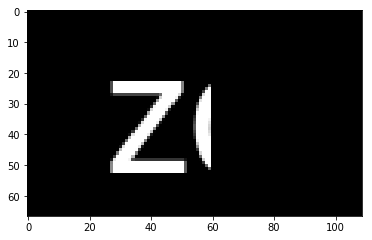

IndexError: ignored

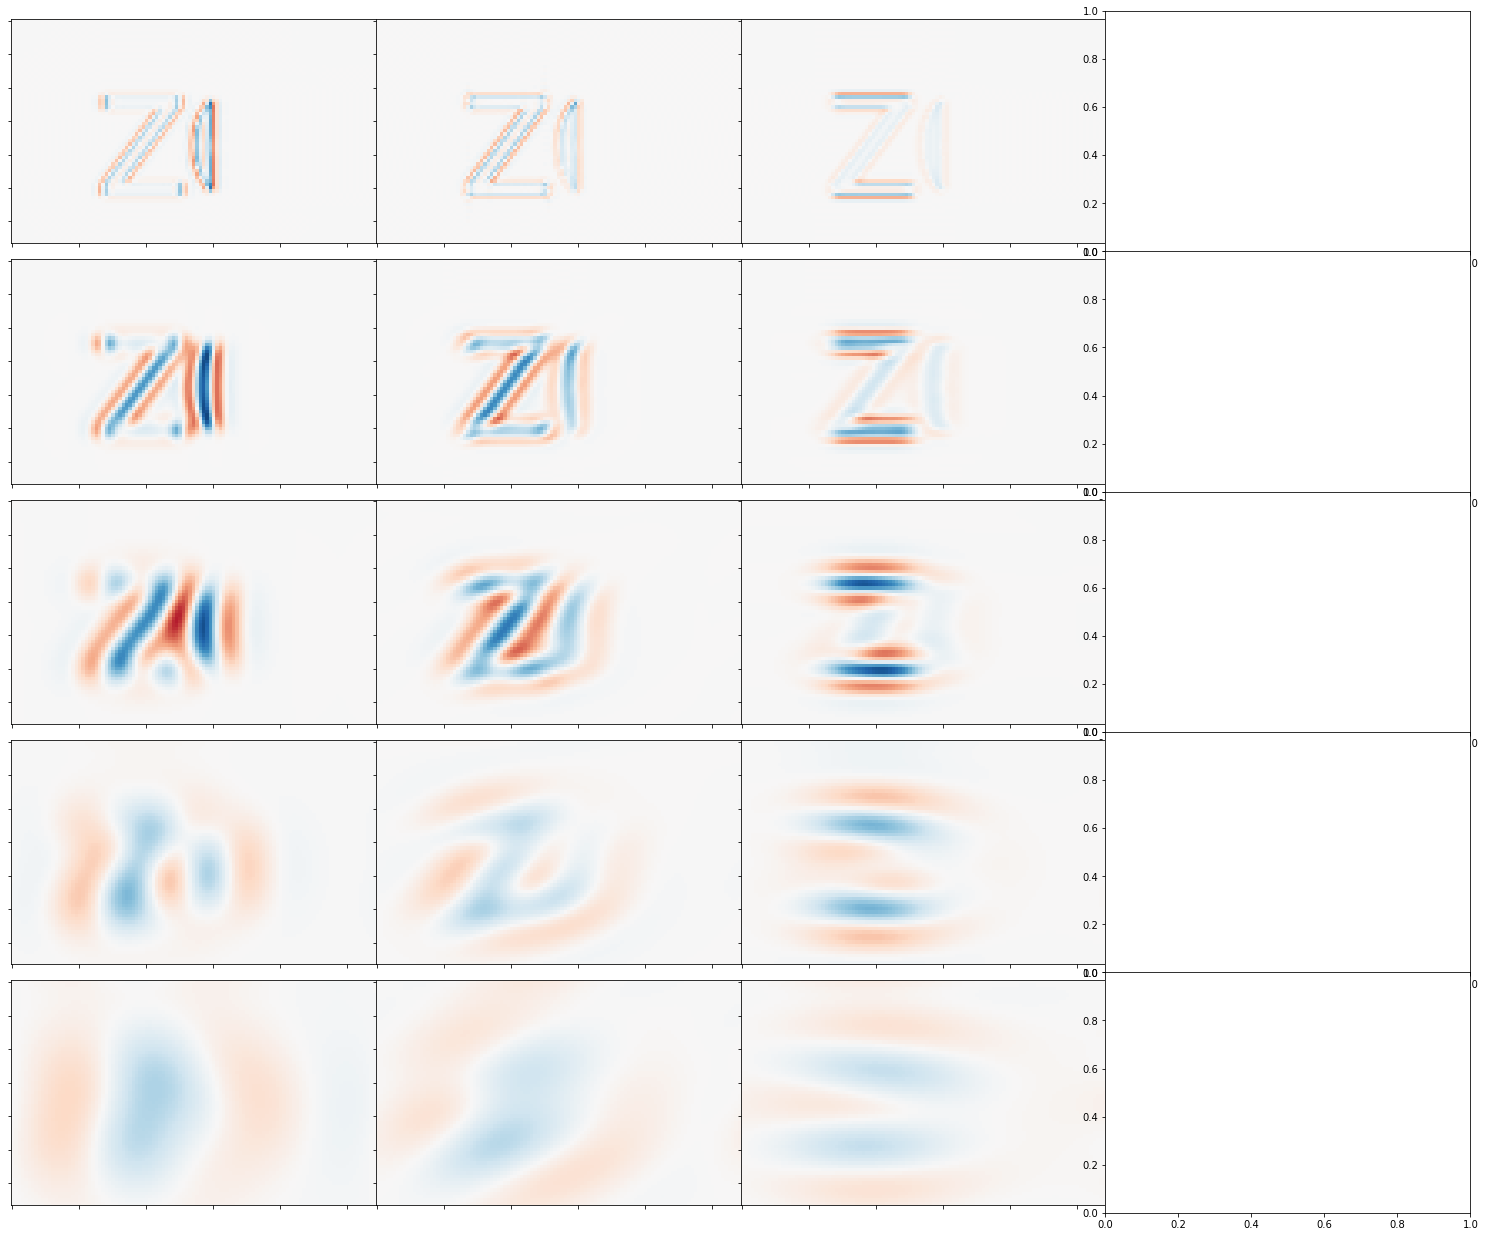

In [0]:
original = sample_input[2][0, :, :, 3].numpy()
original[:, 60:] = 0
input_in_freqdomain = np.fft.fft2(original + 1j * np.zeros_like(original), [box_height, box_width])
shifted_input_in_freqdomain = np.fft.fftshift(input_in_freqdomain, [0, 1])
fft_product = shifted_input_in_freqdomain[:, :, None, None] * filter_bank

fft_product_reshaped = np.einsum("hwso->sohw", fft_product)
filtered_components = np.einsum("sohw->hwso", np.fft.ifft2(np.fft.ifftshift(fft_product_reshaped, [2, 3]), [box_height, box_width])).astype(np.complex64)

plt.imshow(original, cmap='gray')
plt.show()
size_factor = 6

fig, ax = plt.subplots(nrows=n_sizes//2, ncols=n_orientations,  gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(size_factor * n_orientations * box_width / 100, size_factor * n_sizes * box_height / 200))
for si in range(0, n_sizes, 2):
    for oi in range(0, n_orientations-1):
        ax[si//2, oi].imshow(np.real(filtered_components[:, :, si, oi]), cmap='RdBu', vmin=-0.2, vmax=0.2)
        ax[si//2, oi].set_xticklabels([])
        ax[si//2, oi].set_yticklabels([])
plt.show()
fig, ax = plt.subplots(nrows=n_sizes//2, ncols=n_orientations,  gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(size_factor * n_orientations * box_width / 100, size_factor * n_sizes * box_height / 200))
for si in range(0, n_sizes, 2):
    for oi in range(0, n_orientations-1):
        ax[si//2, oi].imshow(np.imag(filtered_components[:, :, si, oi]), cmap='RdBu', vmin=-.2, vmax=.2)
        ax[si//2, oi].set_xticklabels([])
        ax[si//2, oi].set_yticklabels([])
plt.show()


# We are solving an optimization problem:
# Find an image which, when convolved, results in the same edges, but zero lines
tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session()

class AddNoise(tf.keras.layers.Layer):
    def __init__(self):
        super(AddNoise, self).__init__()
        self.noise = self.add_weight(shape=(1, box_height, box_width),
                                       initializer='normal',
                                       name='noise',
                                       trainable=True)
    def call(self, inputs):
        return inputs + self.noise

original_image = tf.keras.Input(shape=(box_height, box_width), name='original_image')
noised_original_image = AddNoise()(original_image)
gs_input_in_freqdomain = tf.signal.fft2d(tf.complex(noised_original_image, tf.zeros_like(original_image)))
gs_shifted_input_in_freqdomain = tf.signal.fftshift(gs_input_in_freqdomain, [1, 2], 'faf')
print("GSFH", gs_shifted_input_in_freqdomain.shape)
#[?,1,67,1,1,109], [1,67,109,11,4].
gs_fft_product = gs_shifted_input_in_freqdomain[:, :, :, None, None] * filter_bank[None, :, :, :, :] # Has to deal with batch dimension
gs_fft_product_reshaped = tf.einsum("bhwso->bsohw", gs_fft_product)
gs_filtered_components = tf.einsum("bsohw->bhwso", tf.signal.ifft2d(tf.signal.ifftshift(gs_fft_product_reshaped, [3, 4], 'ifts')))
simulation_model = tf.keras.Model(inputs=original_image, outputs=gs_filtered_components)

def compute_simulation_loss(original_spectra, simulated_spectra):
    # Use edge congruency.
    # We want minimal line congruency, but unchanged edge congruency.
    #edge_similarity = tf.reduce_sum((tf.math.real(simulated_spectra) - tf.math.real(original_spectra)) ** 2, axis=[1,2,3,4]) / 10000.
    #line_total = tf.reduce_sum(tf.math.imag(simulated_spectra) ** 2, axis=[1,2,3,4])
    
    # We want increased phase congruency compared to the local.
    # We will multiply the change in phase congruency by the original phase congruency.

    # Original phase congruency:
    # Original energy:
    #original_pc = tf.abs(tf.reduce_sum(original_spectra, axis=[3, 4])) / tf.reduce_sum(tf.abs(original_spectra), axis=[3, 4])
    #new_pc = tf.abs(tf.reduce_sum(simulated_spectra, axis=[3, 4])) / tf.reduce_sum(tf.abs(simulated_spectra), axis=[3, 4])
    original_line_pc = tf.abs(tf.math.real(tf.reduce_sum(original_spectra, axis=[3, 4]))) / tf.reduce_sum(tf.abs(original_spectra), axis=[3, 4])
    new_line_pc = tf.abs(tf.math.real(tf.reduce_sum(simulated_spectra, axis=[3, 4]))) / tf.reduce_sum(tf.abs(simulated_spectra), axis=[3, 4])
    original_edge_pc = tf.abs(tf.math.imag(tf.reduce_sum(original_spectra, axis=[3, 4]))) / tf.reduce_sum(tf.abs(original_spectra), axis=[3, 4])
    new_edge_pc = tf.abs(tf.math.imag(tf.reduce_sum(simulated_spectra, axis=[3, 4]))) / tf.reduce_sum(tf.abs(simulated_spectra), axis=[3, 4])
    line_similarity = (new_edge_pc) ** 2
    edge_similarity = (new_line_pc - original_line_pc) ** 2
    # We want the edge pcs to be unchanged, but lines to be zero
    return -tf.reduce_sum(line_similarity + edge_similarity)

simulation_model.compile(loss=compute_simulation_loss, optimizer=tf.keras.optimizers.Adam(0.04))
for i in range(1):
    simulation_model.fit(original[None, :, :], filtered_components[None, ...],
                        epochs=1, steps_per_epoch=1, use_multiprocessing=False)
    print("Step", i)
    if i % 10 == 0:
        output = (original + simulation_model.layers[1].get_weights()[0])[0, :, :]
        plt.imshow(output)
        plt.colorbar()
        plt.show()
tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session()




## Model evaluator

[[4.41217646e-02 1.43842712e-01 1.45181045e-01 1.26688361e-01
  1.08833164e-01 9.43010524e-02 8.27613100e-02 7.35378861e-02
  6.60607964e-02 5.99060059e-02 5.47658168e-02]
 [3.38301092e-04 3.72054987e-02 9.43049639e-02 1.21294782e-01
  1.26576185e-01 1.22423328e-01 1.14980802e-01 1.06829457e-01
  9.89770517e-02 9.17731225e-02 8.52964893e-02]
 [2.45388520e-07 5.12839900e-03 3.90558876e-02 8.19589794e-02
  1.11988150e-01 1.27327293e-01 1.32610947e-01 1.32089853e-01
  1.28511965e-01 1.23472162e-01 1.17856115e-01]
 [0.00000000e+00 4.12031543e-04 1.25743365e-02 4.53141890e-02
  8.35676119e-02 1.14858091e-01 1.35799646e-01 1.47730172e-01
  1.53121397e-01 1.54162601e-01 1.52459890e-01]
 [0.00000000e+00 1.84057189e-05 3.24355951e-03 2.20068358e-02
  5.60122989e-02 9.42191258e-02 1.28002003e-01 1.53839365e-01
  1.71605751e-01 1.82607397e-01 1.88445255e-01]
 [0.00000000e+00 4.55423759e-07 6.59089244e-04 9.51794628e-03
  3.47888209e-02 7.24849701e-02 1.13870516e-01 1.52110085e-01
  1.83728009e-01

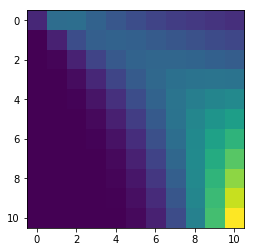

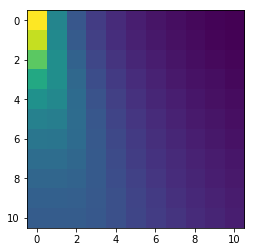

In [0]:
tf.keras.backend.clear_session()  # For easy reset of notebook state.
full_shape = (box_height, box_width, n_sizes, n_orientations, n_sample_distances)

@tf.function
def nd_softmax(target, axis, name=None):
    max_axis = tf.reduce_max(target, axis, keepdims=True)
    target_exp = tf.exp(target - max_axis)
    normalize = tf.reduce_sum(target_exp, axis, keepdims=True)
    softmax = target_exp / (normalize + 1.e-7)
    return softmax

@tf.function
def tilo(t):
    return tf.concat([t[:, :, :, :, 0:1, :], t[:, :, :, :, 1:2, :], t[:, :, :, :, 2:3, :], t[:, :, :, :, 1:2, :]], axis=4)
@tf.function
def tilop(t):
    return tf.nn.softplus(tilo(t))
@tf.function
def tiloa(t):
    return tf.concat([t[:, :, :, :, 0:1, :, :], t[:, :, :, :, 1:2, :, :], t[:, :, :, :, 2:3, :, :], t[:, :, :, :, 1:2, :, :]], axis=4)
@tf.function
def tiloap(t):
    return tf.nn.softplus(tiloa(t))

# Convolution initializer
c_lines = np.zeros((n_sizes, n_sizes)).astype(np.float32)
c_edges = np.zeros((n_sizes, n_sizes)).astype(np.float32)
for si in range(n_sizes):
    for sj in range(n_sizes):
        sis = (box_width*0.34-1.5)*(si-3)**2/(n_sizes-1)**2 + 1.5
        sjs = (box_width*0.34-1.5)*(sj)**2/(n_sizes-1)**2 + 1.5 
        sis = si + 1
        sjs = sj + 1
        c_lines[si, sj] = 0.5*tf.math.erf(2.357*sis/sjs) - 0.5*tf.math.erf(1.178*sis/sjs)
        c_edges[si, sj] = 0.5*(tf.math.erf((sis-sjs)/(1.414*sjs))+tf.math.erf((sjs+sis)/(1.414*sjs)))

c_lines /= np.sum(c_lines, (1))[:, None]
c_edges /= np.sum(c_edges, (1))[:, None]
print(c_lines)
print(c_edges)
plt.imshow(c_lines)
plt.show()
plt.imshow(c_edges)
plt.show()

class SizeOrientationWeighting(tf.keras.layers.Layer):
    def __init__(self):
        super(SizeOrientationWeighting, self).__init__()
        self.size_orientation_weights = self.add_weight(shape=(1, 1, 1, n_sizes, n_orientations - 1, 1),
                                       initializer=tf.keras.initializers.Ones(),
                                       name='size_orientation_weights',
                                       trainable=True)
    def call(self, inputs):
        return inputs * tf.complex(tilop(self.size_orientation_weights), tf.zeros((1, 1, 1, n_sizes, n_orientations, 1)))

class NonnegativeSizeConvolution(tf.keras.layers.Layer):
    def __init__(self, kernel_size=5):
        super(NonnegativeSizeConvolution, self).__init__()
        self.line_dense_weights = self.add_weight(shape=(n_sizes, n_sizes),
                                               initializer=tf.keras.initializers.Constant(c_lines),
                                               name='line_dense_weights',
                                               trainable=False)
        self.edge_dense_weights = self.add_weight(shape=(n_sizes, n_sizes),
                                               initializer=tf.keras.initializers.Constant(c_edges),
                                               name='edge_dense_weights',
                                               trainable=False)
    def call(self, inputs):
        lines = tf.math.real(inputs)
        edges = tf.math.imag(inputs)
        line_strengths = tf.abs(tf.einsum("bhwsod,ps->bhwpod", lines, self.line_dense_weights))
        edge_strengths = tf.abs(tf.einsum("bhwsod,ps->bhwpod", edges, self.edge_dense_weights))

        #lines_flat = tf.reshape(tf.einsum("bhwsod->bhwdos", lines), [batch_size * box_height * box_width * n_sample_distances * n_orientations, n_sizes, 1])
        #edges_flat = tf.reshape(tf.einsum("bhwsod->bhwdos", edges), [batch_size * box_height * box_width * n_sample_distances * n_orientations, n_sizes, 1])
        #lines_conv_flat = tf.nn.conv1d(lines_flat, tf.nn.softplus(self.line_conv_kernel), padding="SAME", stride=1)
        #edges_conv_flat = tf.nn.conv1d(edges_flat, tf.nn.softplus(self.edge_conv_kernel), padding="SAME", stride=1)
        #lines_conv = tf.abs(tf.einsum("bhwdos->bhwsod", tf.reshape(lines_conv_flat, [batch_size, box_height, box_width, n_sample_distances, n_orientations, n_sizes])))
        #edges_conv = tf.abs(tf.einsum("bhwdos->bhwsod", tf.reshape(edges_conv_flat, [batch_size, box_height, box_width, n_sample_distances, n_orientations, n_sizes])))
        return tf.complex(line_strengths, edge_strengths)

class HRAPC(tf.keras.layers.Layer):
    def __init__(self):
        super(HRAPC, self).__init__()

        self.factors = self.add_weight(shape=(1, 1, 1, n_sizes, n_orientations - 1, 1),
                                       initializer=tf.keras.initializers.Constant(1.0),
                                       name='hrapc_factors',
                                       trainable=True)
        self.exponents = self.add_weight(shape=(1, 1, 1, n_sizes, n_orientations - 1, 1),
                                       initializer=tf.keras.initializers.Constant(3.0),
                                       name='hrapc_exponents',
                                       trainable=True)
        self.alphas = self.add_weight(shape=(1, 1, 1, n_sizes, n_orientations - 1, 1),
                                       initializer=tf.keras.initializers.Constant(1.0),
                                       name='hrapc_alpha',
                                       trainable=True)
    def call(self, inputs):
        tpfactor = tiloap(self.factors)
        tpexponents = tiloap(self.exponents)
        tpalphas = tiloap(self.alphas)

        abs_in = tf.abs(inputs)
        hr_abs_in = (tpfactor*abs_in**tpexponents) / (1.e-7 + tpalphas**tpexponents + abs_in**tpexponents)
        hrapc = tf.reduce_sum(hr_abs_in, axis=[3], keepdims=True)
        return hrapc

class SizeOrientationHyperbolicRatio(tf.keras.layers.Layer):
    def __init__(self):
        super(SizeOrientationHyperbolicRatio, self).__init__()
        self.factor = self.add_weight(shape=(1, 1, 1, n_sizes, n_orientations - 1, 1, 2),
                                     initializer=tf.keras.initializers.Constant(-2.25), # * 300
                                     name='size_orientation_factor',
                                     trainable=True)
        self.alpha = self.add_weight(shape=(1, 1, 1, n_sizes, n_orientations - 1, 1, 2),
                                     initializer=tf.keras.initializers.Constant(-2.25), # * 100
                                     name='size_orientation_alpha',
                                     trainable=False)
        self.exponent = self.add_weight(shape=(1, 1, 1, n_sizes, n_orientations - 1, 1, 2),
                                     initializer=tf.keras.initializers.Constant(-2.25), # * 20
                                     name='size_orientation_exponent',
                                     trainable=False)
    def call(self, inputs):
        tpfactor = tiloap(self.factor) * 300.
        #tpexponent = tiloap(self.exponent) * 20.
        #tpalpha = tiloap(self.alpha) * 100.
        flat_inputs = tf.stack([tf.math.real(inputs), tf.math.imag(inputs)], axis=6)
        #hr = (tpfactor * flat_inputs ** tpexponent / (1.e-7 + tpalpha ** tpexponent + flat_inputs ** tpexponent))
        hr = tpfactor * flat_inputs ** 2
        return hr #tf.complex(hr[..., 0] + 1.e-7, hr[..., 1] + 1.e-7) #tf.complex(tf.math.real(inputs)**2 + 1.e-7, tf.math.imag(inputs)**2 + 1.e-7) #


class SizeOrientationNormalization(tf.keras.layers.Layer):
    def __init__(self):
        super(SizeOrientationNormalization, self).__init__()
        self.saliency_weights = self.add_weight(shape=(n_sizes * n_orientations * 2),
                                                initializer=tf.keras.initializers.Constant(10.),
                                                name='saliency_weight',
                                                trainable=True)
        self.normalization_weights = self.add_weight(shape=(n_sizes * n_orientations * 2, n_sizes * n_orientations * 2),
                                                     initializer=tf.keras.initializers.Constant(0.5),
                                                     name='normalization_weights',
                                                     trainable=True)
        self.normalization_constant = self.add_weight(shape=(n_sizes * n_orientations * 2),
                                                      initializer=tf.keras.initializers.Constant(1.0),
                                                      name='normalization_constant',
                                                      trainable=True)
    def call(self, inputs):
        # Input is <b, h, w, s, o, d, a>
        # Normalize over s, o, and a
        
        flat_inputs = tf.reshape(tf.einsum("bhwsoda->bhwdsoa", inputs), # shape: <b, h, w, d, s*o*a>
                                 [batch_size, box_height, box_width, n_sample_distances, n_sizes * n_orientations * 2])
        normalization_pool = tf.einsum("bhwdx,xy->bhwdy", flat_inputs, tf.nn.relu(self.normalization_weights))
        normalized_flat_inputs = (self.saliency_weights[None, None, None, None, :] * flat_inputs /
                                  (1.e-7 + tf.nn.relu(self.normalization_constant[None, None, None, None, :]) + tf.nn.relu(normalization_pool)))
        normalized_output = tf.einsum("bhwdsoa->bhwsoda", tf.reshape(normalized_flat_inputs,
                                                                     [batch_size, box_height, box_width, n_sample_distances, n_sizes, n_orientations, 2]))
        return normalized_output

class TotalHyperbolicRatio(tf.keras.layers.Layer):
    def __init__(self):
        super(TotalHyperbolicRatio, self).__init__()
        self.factor = self.add_weight(shape=(),
                                     initializer=tf.keras.initializers.Constant(30.0),
                                     name='total_factor',
                                     trainable=False)
        self.alpha = self.add_weight(shape=(),
                                     initializer=tf.keras.initializers.Constant(10.),
                                     name='total_alpha',
                                     trainable=False)
        self.exponent = self.add_weight(shape=(),
                                     initializer=tf.keras.initializers.Constant(2.0),
                                     name='total_exponent',
                                     trainable=False)
    def call(self, inputs):
        #tfactor = tf.nn.softplus(self.factor)
        #texponent = tf.nn.softplus(self.exponent)
        #talpha = tf.nn.softplus(self.alpha)
        return inputs
        #return (tfactor * inputs ** texponent / (1.e-7 + talpha ** texponent + inputs ** texponent))

class DistanceEstimator(tf.keras.layers.Layer):
    def __init__(self):
        super(DistanceEstimator, self).__init__()

    def call(self, inputs):
        y, x = inputs
        xdelta = (x[:, 1:] - x[:, :-1])
        ydelta = (y[:, 1:] - y[:, :-1]) # Positive when upward
    
        yrange = (tf.reduce_max(y, axis=[1], keepdims=True) - tf.reduce_min(y, axis=[1], keepdims=True)) + 1.e-7
        estimate_validities = nd_softmax(1e3 * y/yrange, axis=[1])
        estimated_distances = tf.reduce_sum(estimate_validities * x, axis=[1], name='estimated_distances')
        return estimated_distances

def get_model():
    pair_filtered_images = tf.keras.Input(shape=full_shape, name='pair_filtered_images', dtype=tf.complex64)

    # Step 1. Convolution over sizes, with abs
    #d = NonnegativeSizeConvolution()(pair_filtered_images)

    # Step 2. Nonlinearity
    #d = SizeOrientationHyperbolicRatio()(d)

    # Step 3. GDN
    #d = SizeOrientationNormalization()(d)
    # Step 1. HRAPC
    d = HRAPC()(pair_filtered_images)

    # Step 2. Add for each pixel
    d = tf.reduce_sum(d, axis=[3, 4, 6], name="per_pixel_sum")
    
    # Step 5. Nonlinearity
    #d = TotalHyperbolicRatio()(d)

    # Step 3. Sum
    d = tf.reduce_sum(d, axis=[1,2], name="total_sum")

    sample_distances = tf.keras.Input(shape=(n_sample_distances), name='sample_distances')
    pair_images = tf.keras.Input(shape=(box_height, box_width, n_sample_distances), name='pair_images')
    zero_indices = tf.keras.Input(shape=(), name='zero_indices')

    # Step 10. Estimate best distance
    predicted_ink_distances = DistanceEstimator()([d, sample_distances])

    return tf.keras.Model(inputs=[pair_filtered_images, sample_distances, pair_images, zero_indices], outputs=predicted_ink_distances)

@tf.function
def compute_loss(target_ink_distance, predicted_ink_distance):
    return tf.sqrt(1.e-7 + tf.reduce_sum((target_ink_distance - predicted_ink_distance[0]) ** 2) / batch_size, name='sqrt') * 100 / factor


## Monitoring

In [0]:
class MonitorProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, data_generator):
        self.data_generator = data_generator

    def on_test_batch_end(self, batch_index, logs=None):
        dataset = self.data_generator[batch_index]
        current_data = dataset[0]
        filtered_pair_images, sample_distances, pair_images, zero_indices = current_data

        iix = 0
        
        print("Total abs, before applying weights")
        plt.imshow(tf.reduce_sum(tf.math.real(filtered_pair_images), axis=[3, 4], keepdims=True)[iix, :, :, 0, 0, zero_indices[iix]])
        plt.colorbar()
        plt.show()
        plt.imshow(tf.reduce_sum(tf.math.imag(filtered_pair_images), axis=[3, 4], keepdims=True)[iix, :, :, 0, 0, zero_indices[iix]])
        plt.colorbar()
        plt.show()

        print("Size convolution kernel")
        plt.imshow(self.model.layers[1].get_weights()[0][:, :])
        plt.colorbar()
        plt.show()
        plt.imshow(self.model.layers[1].get_weights()[1][:, :])
        plt.colorbar()
        plt.show()

        if True:
            print("After s/o dense convolution: lines, edges")
            out = tf.keras.backend.function([model.layers[0].input], [model.layers[2].output])(current_data)[0]
            max_line = tf.reduce_max(out[iix, :, :, :, :, zero_indices[iix], 0])
            max_edge = tf.reduce_max(out[iix, :, :, :, :, zero_indices[iix], 1])
            print("Line max value:", max_line)
            print("Edge max value:", max_edge)
            size_factor = 2
            fig, ax = plt.subplots(nrows=n_sizes, ncols=n_orientations,  gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(size_factor * n_orientations * box_width / 100, size_factor * n_sizes * box_height / 100))
            for si in range(n_sizes):
                for oi in range(n_orientations):
                    ax[si, oi].imshow(out[iix, :, :, si, oi, zero_indices[iix], 0], vmax=max_line)
                    ax[si, oi].set_xticklabels([])
                    ax[si, oi].set_yticklabels([])
            plt.show()
            fig, ax = plt.subplots(nrows=n_sizes, ncols=n_orientations,  gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(size_factor * n_orientations * box_width / 100, size_factor * n_sizes * box_height / 100))
            for si in range(n_sizes):
                for oi in range(n_orientations):
                    ax[si, oi].imshow(out[iix, :, :, si, oi, zero_indices[iix], 1], vmax=max_edge)
                    ax[si, oi].set_xticklabels([])
                    ax[si, oi].set_yticklabels([])
            plt.show()

        if True:
            print("After dense convolution and normalization: lines, edges")
            out = tf.keras.backend.function([model.layers[0].input], [model.layers[3].output])(current_data)[0]
            max_line = tf.reduce_max(out[iix, :, :, :, :, zero_indices[iix], 0])
            max_edge = tf.reduce_max(out[iix, :, :, :, :, zero_indices[iix], 1])
            print("Line max value:", max_line)
            print("Edge max value:", max_edge)
            size_factor = 2
            fig, ax = plt.subplots(nrows=n_sizes, ncols=n_orientations,  gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(size_factor * n_orientations * box_width / 100, size_factor * n_sizes * box_height / 100))
            for si in range(n_sizes):
                for oi in range(n_orientations):
                    ax[si, oi].imshow(out[iix, :, :, si, oi, zero_indices[iix], 0], vmax=max_line)
                    ax[si, oi].set_xticklabels([])
                    ax[si, oi].set_yticklabels([])
            plt.show()
            fig, ax = plt.subplots(nrows=n_sizes, ncols=n_orientations,  gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(size_factor * n_orientations * box_width / 100, size_factor * n_sizes * box_height / 100))
            for si in range(n_sizes):
                for oi in range(n_orientations):
                    ax[si, oi].imshow(out[iix, :, :, si, oi, zero_indices[iix], 1], vmax=max_edge)
                    ax[si, oi].set_xticklabels([])
                    ax[si, oi].set_yticklabels([])
            plt.show()

            #plt.imshow(tf.reduce_sum(tf.math.real(out), axis=[3, 4], keepdims=True)[iix, :, :, 0, 0, zero_indices[iix]])
            #plt.colorbar()
            #plt.show()
            #plt.imshow(tf.reduce_sum(tf.math.imag(out), axis=[3, 4], keepdims=True)[iix, :, :, 0, 0, zero_indices[iix]])
            #plt.colorbar()
            #plt.show()

        print("Hyperbolic ratio variables")
        plt.imshow(tf.nn.softplus(self.model.layers[2].get_weights()[0][0, 0, 0, :, :, 0, 0]) * 100.)
        plt.colorbar()
        plt.show()
        plt.imshow(tf.nn.softplus(self.model.layers[2].get_weights()[0][0, 0, 0, :, :, 0, 1]) * 100.)
        plt.colorbar()
        plt.show()
        #plt.imshow(tf.nn.softplus(self.model.layers[2].get_weights()[1][0, 0, 0, :, :, 0, 0]) * 20.)
        #plt.colorbar()
        #plt.show()
        #plt.imshow(tf.nn.softplus(self.model.layers[2].get_weights()[2][0, 0, 0, :, :, 0, 0]) * 300.)
        #plt.colorbar()
        #plt.show()

        print("Normalization weights: Saliency, weights")
        plt.imshow(self.model.layers[3].get_weights()[0].reshape((n_sizes, n_orientations * 2)))
        plt.colorbar()
        plt.show()
        plt.imshow(self.model.layers[3].get_weights()[1])
        plt.colorbar()
        plt.show()

        print("Total for each pixel")
        out = tf.keras.backend.function([model.layers[0].input], [model.layers[4].output])(current_data)[0]
        plt.imshow(out[iix, :, :, zero_indices[iix]])
        plt.colorbar()
        plt.show()
        #for i in range(n_sample_distances):
        #    plt.imshow(tf.reduce_sum(out, axis=[3,4], keepdims=True)[iix, :, :, 0, 0, i])
        #    plt.colorbar()
        #    plt.show()
        #    print("Index:", i, "total is", tf.reduce_sum(out, axis=[1,2,3,4])[iix, i])

        print("Diglyphiness values")
        out = tf.keras.backend.function([model.layers[0].input], [model.layers[6].output])(current_data)[0]
        pred = tf.keras.backend.function([model.layers[10].input], [model.layers[10].output])([out, sample_distances])[0]
        plt.plot(sample_distances[iix, :], out[iix, :])
        print("Pred distance is", pred[iix])
        plt.scatter([pred[iix]], [0])
        plt.show()


## Keras pipeline setup

models [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f8800ad7860>, <__main__.NonnegativeSizeConvolution object at 0x7f8800ad7748>, <__main__.SizeOrientationHyperbolicRatio object at 0x7f87fef79128>, <__main__.SizeOrientationNormalization object at 0x7f87feef77f0>, <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f87fed12278>, <__main__.TotalHyperbolicRatio object at 0x7f87ff1c2cf8>, <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f87fecceeb8>, <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f87feccef98>, <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f87fecce978>, <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f87fecce4e0>, <__main__.DistanceEstimator object at 0x7f87fecce3c8>]
Creating glyph images ...
Epoch 1/1001
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
5/5 [==============================] - 2s 49

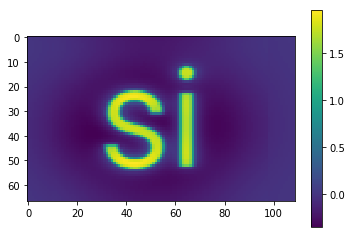

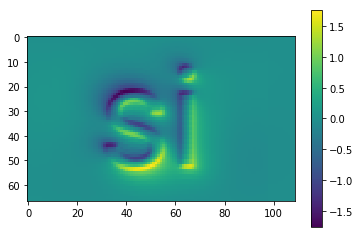

Size convolution kernel


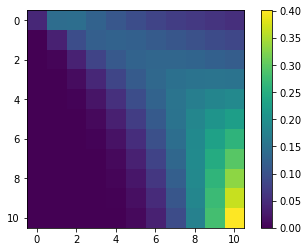

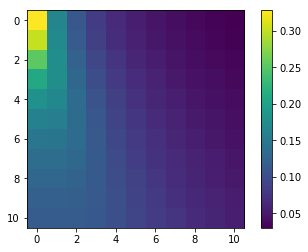

After s/o dense convolution: lines, edges
Line max value: tf.Tensor(0.26505876, shape=(), dtype=float32)
Edge max value: tf.Tensor(0.26200145, shape=(), dtype=float32)


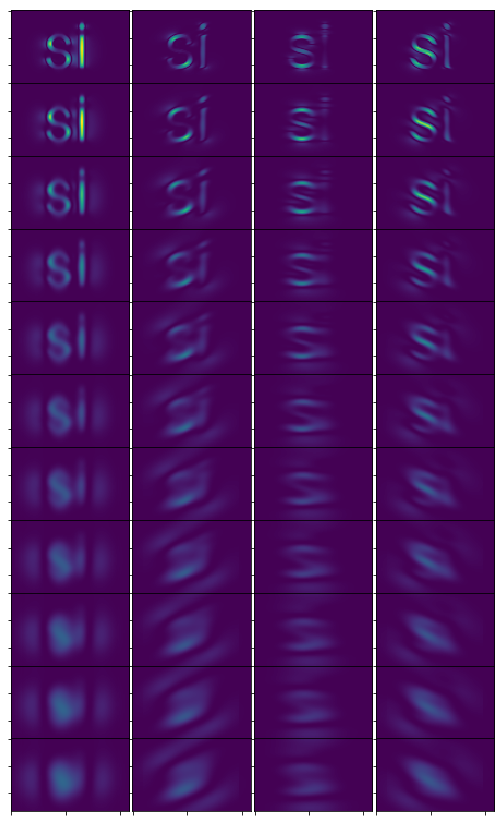

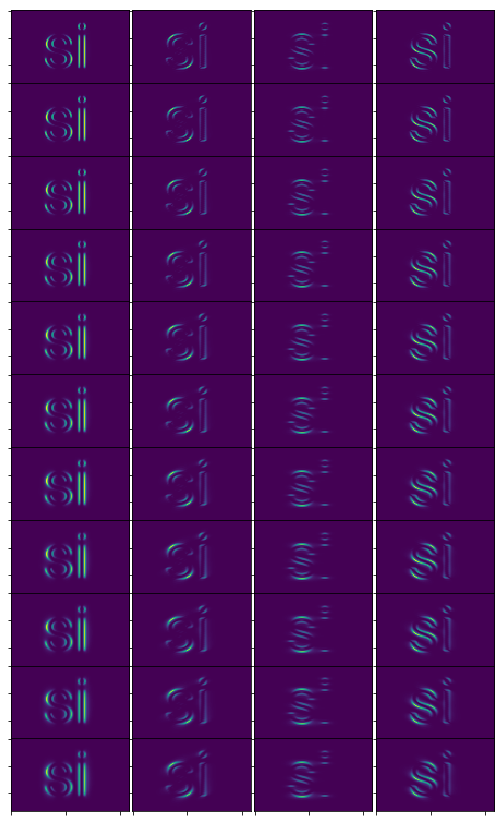

After dense convolution and normalization: lines, edges
Line max value: tf.Tensor(1.3798375, shape=(), dtype=float32)
Edge max value: tf.Tensor(0.836398, shape=(), dtype=float32)


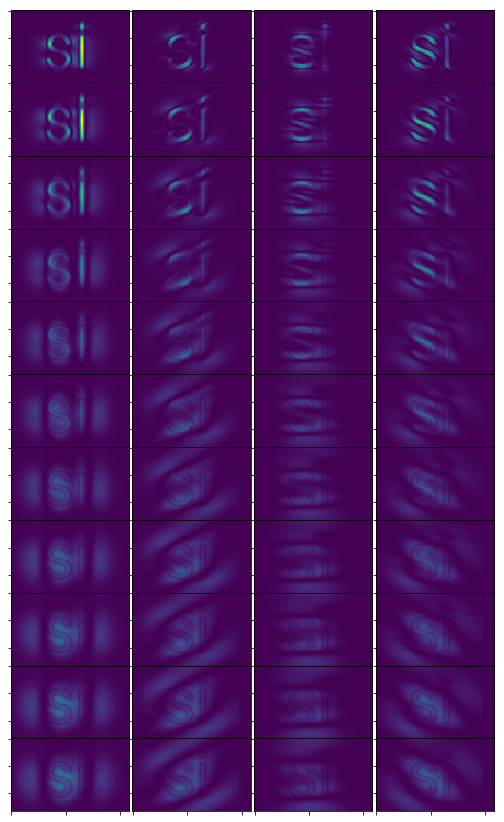

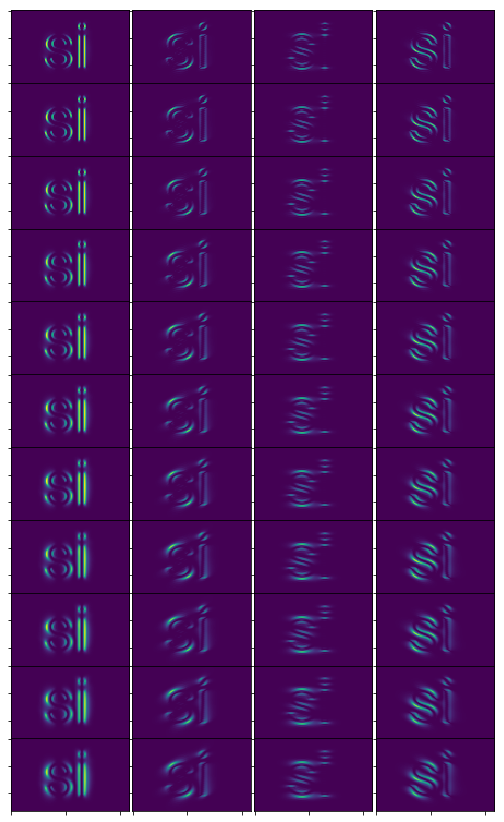

Hyperbolic ratio variables


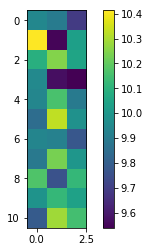

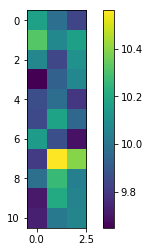

Normalization weights: Saliency, weights


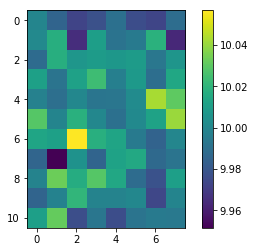

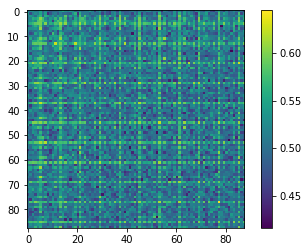

Total for each pixel


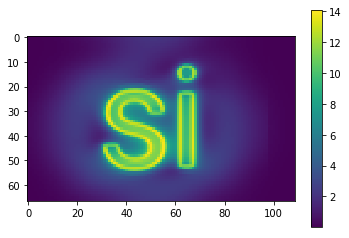

Diglyphiness values
Pred distance is 1.4999998


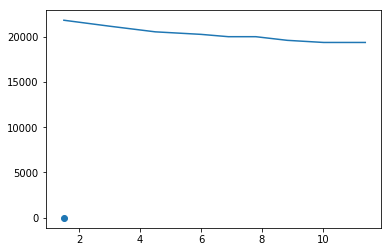

5/5 [==============================] - 22s 4s/step - loss: 540.5584 - val_loss: 523.2938
Epoch 101/1001
5/5 [==============================] - 1s 100ms/step - loss: 611.2035
Epoch 102/1001
5/5 [==============================] - 1s 104ms/step - loss: 677.8702
Epoch 103/1001
5/5 [==============================] - 1s 109ms/step - loss: 553.2008
Epoch 104/1001
5/5 [==============================] - 1s 117ms/step - loss: 526.2691
Epoch 105/1001
5/5 [==============================] - 1s 106ms/step - loss: 606.4016
Epoch 106/1001
5/5 [==============================] - 0s 85ms/step - loss: 647.7376
Epoch 107/1001
5/5 [==============================] - 1s 104ms/step - loss: 519.8675
Epoch 108/1001
5/5 [==============================] - 1s 102ms/step - loss: 550.0000
Epoch 109/1001
5/5 [==============================] - 1s 100ms/step - loss: 436.5342
Epoch 110/1001
5/5 [==============================] - 1s 105ms/step - loss: 383.3334
Epoch 111/1001
5/5 [==============================] - 1s 106ms

KeyboardInterrupt: ignored

In [0]:
tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session()
model = get_model()
model.compile(loss=compute_loss,
            optimizer=tf.keras.optimizers.Adam(0.001))
            #metrics=['accuracy'])
print("models", model.layers)
ig = InputGenerator(batch_size)
history = model.fit_generator(ig,
                            callbacks=[MonitorProgressCallback(ig)],
                            validation_data=ig,
                            validation_steps=1,
                            validation_freq=100,
                            epochs=1001,
                            steps_per_epoch=5, use_multiprocessing=False)
ig.kill()
tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session()